# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

# Understanding of the dataset
The [dataset](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset) contains different 
black and white images of people with different emotions. The emotions classified within the dataset are the following:
- Angry
- Disgust
- Fear
- Happy
- Neutral
- Sad
- Surprise

Additionally, the dataset has already been split for the training set and testing set (named as validation). With this, 
we would be looking at the number of images per each classification for both the training set and testing set

## Checking of label split in dataset
It appears that the training set and testing set has a similar ratio on each of the classifications with the *happy* 
having the most images and *disgust* having the least number of images in both of the sets.

In [2]:
# Fetches the images in all of the folders in the dataset
# Returns a dictionary with the key being the label and the value being the list containing the pathfile to the image 
def get_images(dataset_type):
    folder_paths = glob.glob(f'images/{dataset_type}/*')
    image_dataset = []
    # Process each folder and get all images. Add each of the images to the dataset in pandas
    for folder_path in folder_paths:
        all_images = glob.glob(f"{folder_path}/*.jpg")
        label = folder_path.split('\\')[-1]
        for image in all_images:
            image_data = {'image_path': image, 'label': label}
            image_dataset.append(image_data)
    
    # Transform data into a pandas DataFrame
    image_dataset = pd.DataFrame(image_dataset)
    return image_dataset


# Takes input of a dataframe, and creates a barplot of the distribution of each of the labels of the dataset
def visualize_dataset(dataset: pd.DataFrame(), title = None):
    dataset['label'].value_counts().plot(kind='bar')
    plt.title(title, fontsize=15)
    plt.ylabel('Count')
    plt.xlabel('Emotion')
    plt.show()

In [3]:
training_set = get_images('train')
testing_set = get_images('validation')

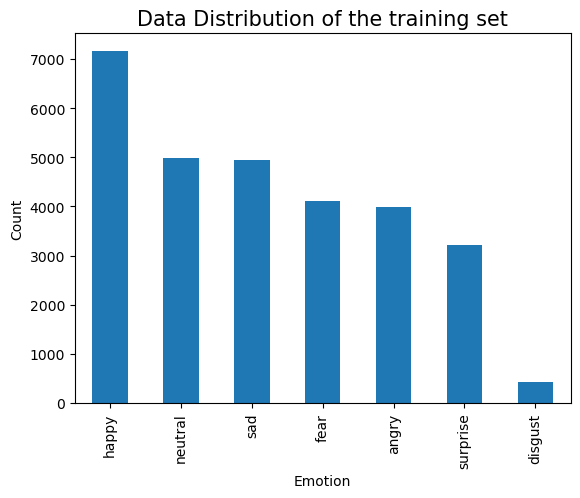

In [4]:
visualize_dataset(training_set, "Data Distribution of the training set")

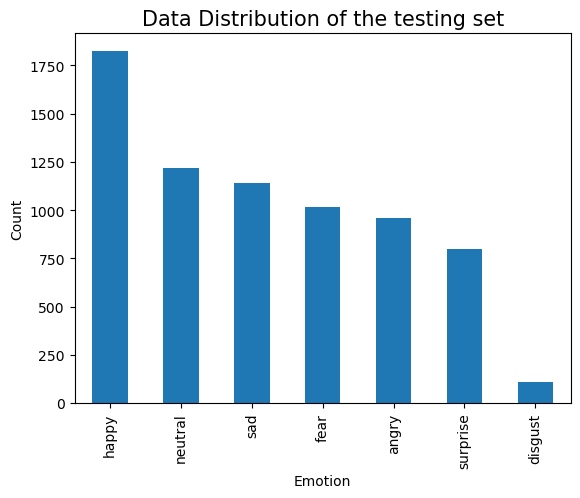

In [5]:
visualize_dataset(testing_set, "Data Distribution of the testing set")

## Checking of Image properties
Now, we'll check a one sample from each of the classification in the dataset to see if there's any preprocessing that 
could be done on the images.

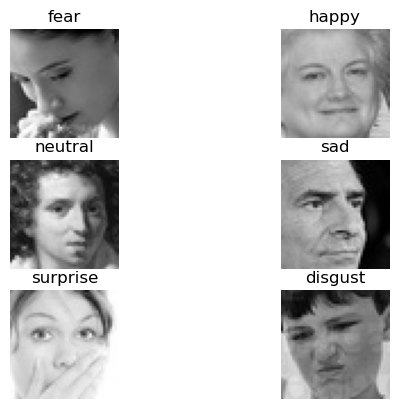

In [37]:
sample_images_path = []

# Getting one image for each of the classification and adding it to sample_images_path
for label in training_set['label'].unique():
    image_path = training_set[training_set['label'] == label]['image_path'].iloc[0]
    sample_images_path.append(image_path)


f, axs = plt.subplots(3,2)
for i in range(len(sample_images_path)):
    image = cv2.imread(sample_images_path[i])
    axs[i//2-1, i%2].axis('off')
    label = sample_images_path[i].split('\\')[-2]
    axs[i//2-1, i%2].title.set_text(label)
    axs[i//2-1, i%2].imshow(image)

(48, 48, 3)
